In [1]:
import pandas as pd
import json

with open("option_columns.json","r") as f:
    option_columns = json.load(f)

#Find the dataset
# df = pd.read_csv("dataset_encoded_size.csv", dtype={k:"int8" for k in option_columns})
df = pd.read_csv("dataset_encoded_all_size.csv", dtype={k:"int8" for k in option_columns})
df.query("cid >= 30000", inplace=True)
df.fillna(-1, inplace=True)
df.query("vmlinux >= 0", inplace=True)



In [2]:
df[:10]

,X86_LOCAL_APIC,OPENVSWITCH,TEXTSEARCH_FSM,LOCKDEP_SUPPORT,GENERIC_CLOCKEVENTS_MIN_ADJUST,NETFILTER_XT_MATCH_TCPMSS,MPLS,NFC_HCI,STACKTRACE_SUPPORT,GENERIC_CMOS_UPDATE,...,XZ-bzImage,XZ-vmlinux,XZ,LZO-bzImage,LZO-vmlinux,LZO,LZ4-bzImage,LZ4-vmlinux,LZ4,cid
14758,1,0,0,1,1,0,1,0,1,1,...,5178320.0,7264848,4980068,8922064.0,11008072,8734199,9839568.0,11925896,9638560,30000
14759,1,0,0,1,1,0,0,0,1,1,...,2840016.0,4924448,2695928,4519376.0,6603288,4385061,4838864.0,6923096,4693085,30001
14760,1,0,0,1,1,0,0,0,1,1,...,8496592.0,10581024,8351248,12391888.0,14475800,12256864,13362640.0,15446872,13214970,30002
14761,1,0,0,1,1,0,0,0,1,1,...,6304720.0,8390008,6156724,8782800.0,10867576,8647251,9302992.0,11388080,9155423,30003
14762,1,0,0,1,1,0,0,1,1,1,...,12321744.0,14407032,12176312,17933264.0,20018040,17796721,19346384.0,21431472,19197696,30004
14763,1,0,1,1,1,0,0,0,1,1,...,5161936.0,7247224,5017068,8328144.0,10412920,8193340,8897488.0,10982576,8748171,30005
14764,1,0,0,1,1,0,1,0,1,1,...,6874064.0,8959352,6726164,9491408.0,11576184,9354542,10048464.0,12133552,9901074,30006
14765,1,0,0,1,1,0,0,1,1,1,...,22009616.0,24096560,21843248,33187600.0,35274032,33029312,35424016.0,37510768,35253064,30007
14766,1,0,0,1,1,0,0,0,1,1,...,3953616.0,6038904,3807028,6325200.0,8409976,6188651,6734800.0,8819888,6587832,30008
14767,1,0,0,1,1,0,1,0,1,1,...,6419408.0,8504352,6274964,9085904.0,11170328,8952807,9663440.0,11748184,9518916,30009


In [3]:
NO_ENCODED_VALUE = 0
YES_ENCODED_VALUE = 1
M_ENCODED_VALUE = 2

def nbyes(row):
    return sum(row == YES_ENCODED_VALUE)

def nbno(row):
    return sum(row == NO_ENCODED_VALUE)

def nbmodule(row):
    return sum(row == M_ENCODED_VALUE)

# df.query("kernel_size == 7304656")
# df.query("kernel_size == 7317008").apply(nbyes, axis=1) 
df.query("vmlinux == 7317008").apply(nbyes, axis=1) 

58621    240
dtype: int64

In [4]:
df['nbyes'] = df.apply(nbyes, axis=1)
df['nbno'] = df.apply(nbno, axis=1)
df['nbmodule'] = df.apply(nbmodule, axis=1)
df['nbyesmodule'] = df['nbyes'] + df['nbmodule']

In [86]:
df.sort_values(by='vmlinux', ascending=True)[['vmlinux', 'nbno', 'nbyes', 'nbmodule', 'nbyesmodule']][:10]

,vmlinux,nbno,nbyes,nbmodule,nbyesmodule
109097,7304656,12237,241,0,241
58621,7317008,12238,240,0,240
107213,8716424,11068,741,669,1410
99232,10486184,11131,636,711,1347
99777,10504040,11351,721,406,1127
91160,10504144,10831,847,800,1647
109537,10511608,11226,724,528,1252
80771,10524528,11163,857,458,1315
66399,10572520,10731,816,931,1747
96643,10648928,10926,835,717,1552


In [ ]:
# df.to_pickle("all_size_withyes.pkl")

In [6]:
size_methods = ["vmlinux", "GZIP-bzImage", "GZIP-vmlinux", "GZIP", "BZIP2-bzImage", 
              "BZIP2-vmlinux", "BZIP2", "LZMA-bzImage", "LZMA-vmlinux", "LZMA", "XZ-bzImage", "XZ-vmlinux", "XZ", 
              "LZO-bzImage", "LZO-vmlinux", "LZO", "LZ4-bzImage", "LZ4-vmlinux", "LZ4"]

In [81]:
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np


def run_regressorML(reg, test_size, size_target="vmlinux"):
    assert(size_target in size_methods)
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["cid"]).drop(columns=size_methods), df[size_target], test_size=test_size, random_state=42)  
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    dfErrors = pd.DataFrame({"error":(y_pred - y_test).abs(), "% error":((y_pred - y_test) / y_test).abs()*100})
    return dfErrors["% error"].describe()


In [91]:

   
hyperparams_DT = {
    "criterion": "mse",
    "max_depth": 12,
    "min_samples_leaf": 5,
    "max_leaf_nodes": None,
}

#reg_dt = tree.DecisionTreeRegressor(**hyperparams_DT)
#res_dt = run_regressorML(reg_dt, test_size=0.9)
#res_dt

hyperparams_RF = {
    "max_depth": 18,
    "n_estimators": 5,
    "n_jobs" : -1
}

# reg_rf = ensemble.RandomForestRegressor(**hyperparams_RF)
# res_rf = run_regressorML(reg_rf, test_size=0.98, size_target="XZ")
# res_rf

hyperparams_GB = {
    'learning_rate': 0.1, 
    'max_depth': 5, 
    'n_estimators': 300    
}

reg_gb = GradientBoostingRegressor()
res_gb = run_regressorML(reg_gb, test_size=0.9, size_target="vmlinux")
res_gb


# run_regressorML(ensemble.AdaBoostRegressor(), test_size=0.98, size_target="vmlinux")

count    83224.000000
mean        14.368797
std         17.531345
min          0.000048
25%          4.763345
50%         10.118799
75%         18.029863
max        718.544368
Name: % error, dtype: float64

In [92]:
def mk_ftimportances(reg):
    col = df.drop(columns=["cid"]).drop(columns=size_methods).columns
    importanceSeries = pd.Series(reg.feature_importances_, index=col.values)
    importanceSeries[importanceSeries > 0].sort_values(ascending=False)

    ftimportance = pd.Series(reg.feature_importances_, index=col.values)
    return ftimportance[ftimportance > 0].sort_values(ascending=False)

#ft_dt = mk_ftimportances(reg_dt)
#ft_dt.to_csv("feature_importanceDT.csv", header=True)
#ft_dt

#ft_rf = mk_ftimportances(reg_rf)
#ft_rf.to_csv("feature_importanceRF.csv", header=True)
#ft_rf

ft_gb = mk_ftimportances(reg_gb)
ft_gb.to_csv("feature_importanceGB.csv", header=True)
ft_gb

DEBUG_INFO                     0.395936
nbyes                          0.137846
DEBUG_INFO_REDUCED             0.124427
DEBUG_INFO_SPLIT               0.105223
RANDOMIZE_BASE                 0.050986
X86_NEED_RELOCS                0.034524
UBSAN_SANITIZE_ALL             0.034003
GCOV_PROFILE_ALL               0.008576
KASAN                          0.008447
KASAN_OUTLINE                  0.007396
PCI_ATMEL                      0.005910
MWIFIEX                        0.005128
UBSAN_ALIGNMENT                0.004366
XFS_DEBUG                      0.004032
WILC1000_SPI                   0.003494
ISDN_DRV_AVMB1_AVM_CS          0.003023
MLXSW_SWITCHX2                 0.002683
DEBUG_INFO_DWARF4              0.002280
INFINIBAND_ISERT               0.002213
DWMAC_DWC_QOS_ETH              0.001982
VIDEO_COBALT                   0.001962
INFINIBAND_USNIC               0.001946
HISAX_TELES_CS                 0.001939
SND_SOC_GTM601                 0.001891
VIDEO_FB_IVTV                  0.001823


<Figure size 1440x1440 with 0 Axes>

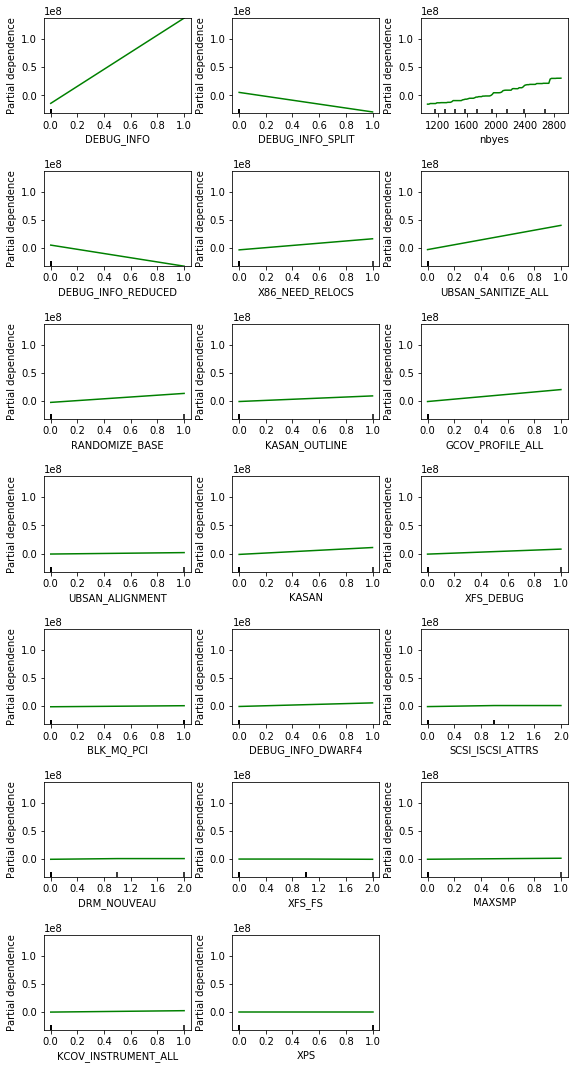

In [93]:
## specific to gradient boosting

####### column' indices of feature importances
# TODO: enhance!
if (True):
    ftIndiceImportanceGB = []
    for ft_name in importanceGB[importanceGB > 0].sort_values(ascending=False).index:
        i = 0
        for vl in col.values:
            if (ft_name == vl):
                ftIndiceImportanceGB.append(i)
    #            print(ft_name, "at", i)
                continue
            i = i + 1
    ftIndiceImportanceGB

    # TODO: instead of plotting, retrieving the coefficients
    col = df.drop(columns=["cid"]).drop(columns=size_methods).columns
    import matplotlib.pyplot as plt
    # TODO: pair-wise feature interactions
    ftsDep = ftIndiceImportanceGB[:20] # importanceGB[importanceGB > 0].sort_values(ascending=False)[:10].values
    plt.figure(figsize=(20, 20))
    # TODO: X_train is an input! (it works only if X_train is accessible/visible)
    fig, ax = plot_partial_dependence(reg_gb, X_train, ftsDep, feature_names=col.values, grid_resolution=100)
    fig.set_figwidth(8)
    fig.set_figheight(15)
    fig.tight_layout()
    plt.show()